# DIP-Project-By RJ Revin Chrisbert, Mohamed Farook SK, Abhishek Rajan K

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Creating Dataframe and Importing Data

In [55]:
import os
import pandas as pd

train_dir = 'D:\Phone\download\DIP practicals\DIP project\DIP Project Skin Cancer\Skin cancer ISIC The International Skin Imaging Collaboration\Train'
test_dir = 'D:\Phone\download\DIP practicals\DIP project\DIP Project Skin Cancer\Skin cancer ISIC The International Skin Imaging Collaboration\Test'

# Create dataframes
# Create lists to hold the data
train_data = []
test_data = []

# Populate the training data list
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

# Create the training DataFrame from the list
train_df = pd.DataFrame(train_data)

# Populate the test data list
for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create the test DataFrame from the list
test_df = pd.DataFrame(test_data)

# Combine train and test df if needed
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the final dataframe
print(df.head())

                                          image_path  label
0  D:\Phone\download\DIP practicals\DIP project\D...      0
1  D:\Phone\download\DIP practicals\DIP project\D...      0
2  D:\Phone\download\DIP practicals\DIP project\D...      0
3  D:\Phone\download\DIP practicals\DIP project\D...      0
4  D:\Phone\download\DIP practicals\DIP project\D...      0


In [56]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

In [57]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


# Loading/resizing of images

In [58]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\REVIN CHRISBERT\AppData\Local\Temp\ipykernel_22684\3886418994.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [59]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [60]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

16

In [61]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [62]:
df.head()

,image_path,label,image
0,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


> # Displaying the total number of images of each Class

In [63]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


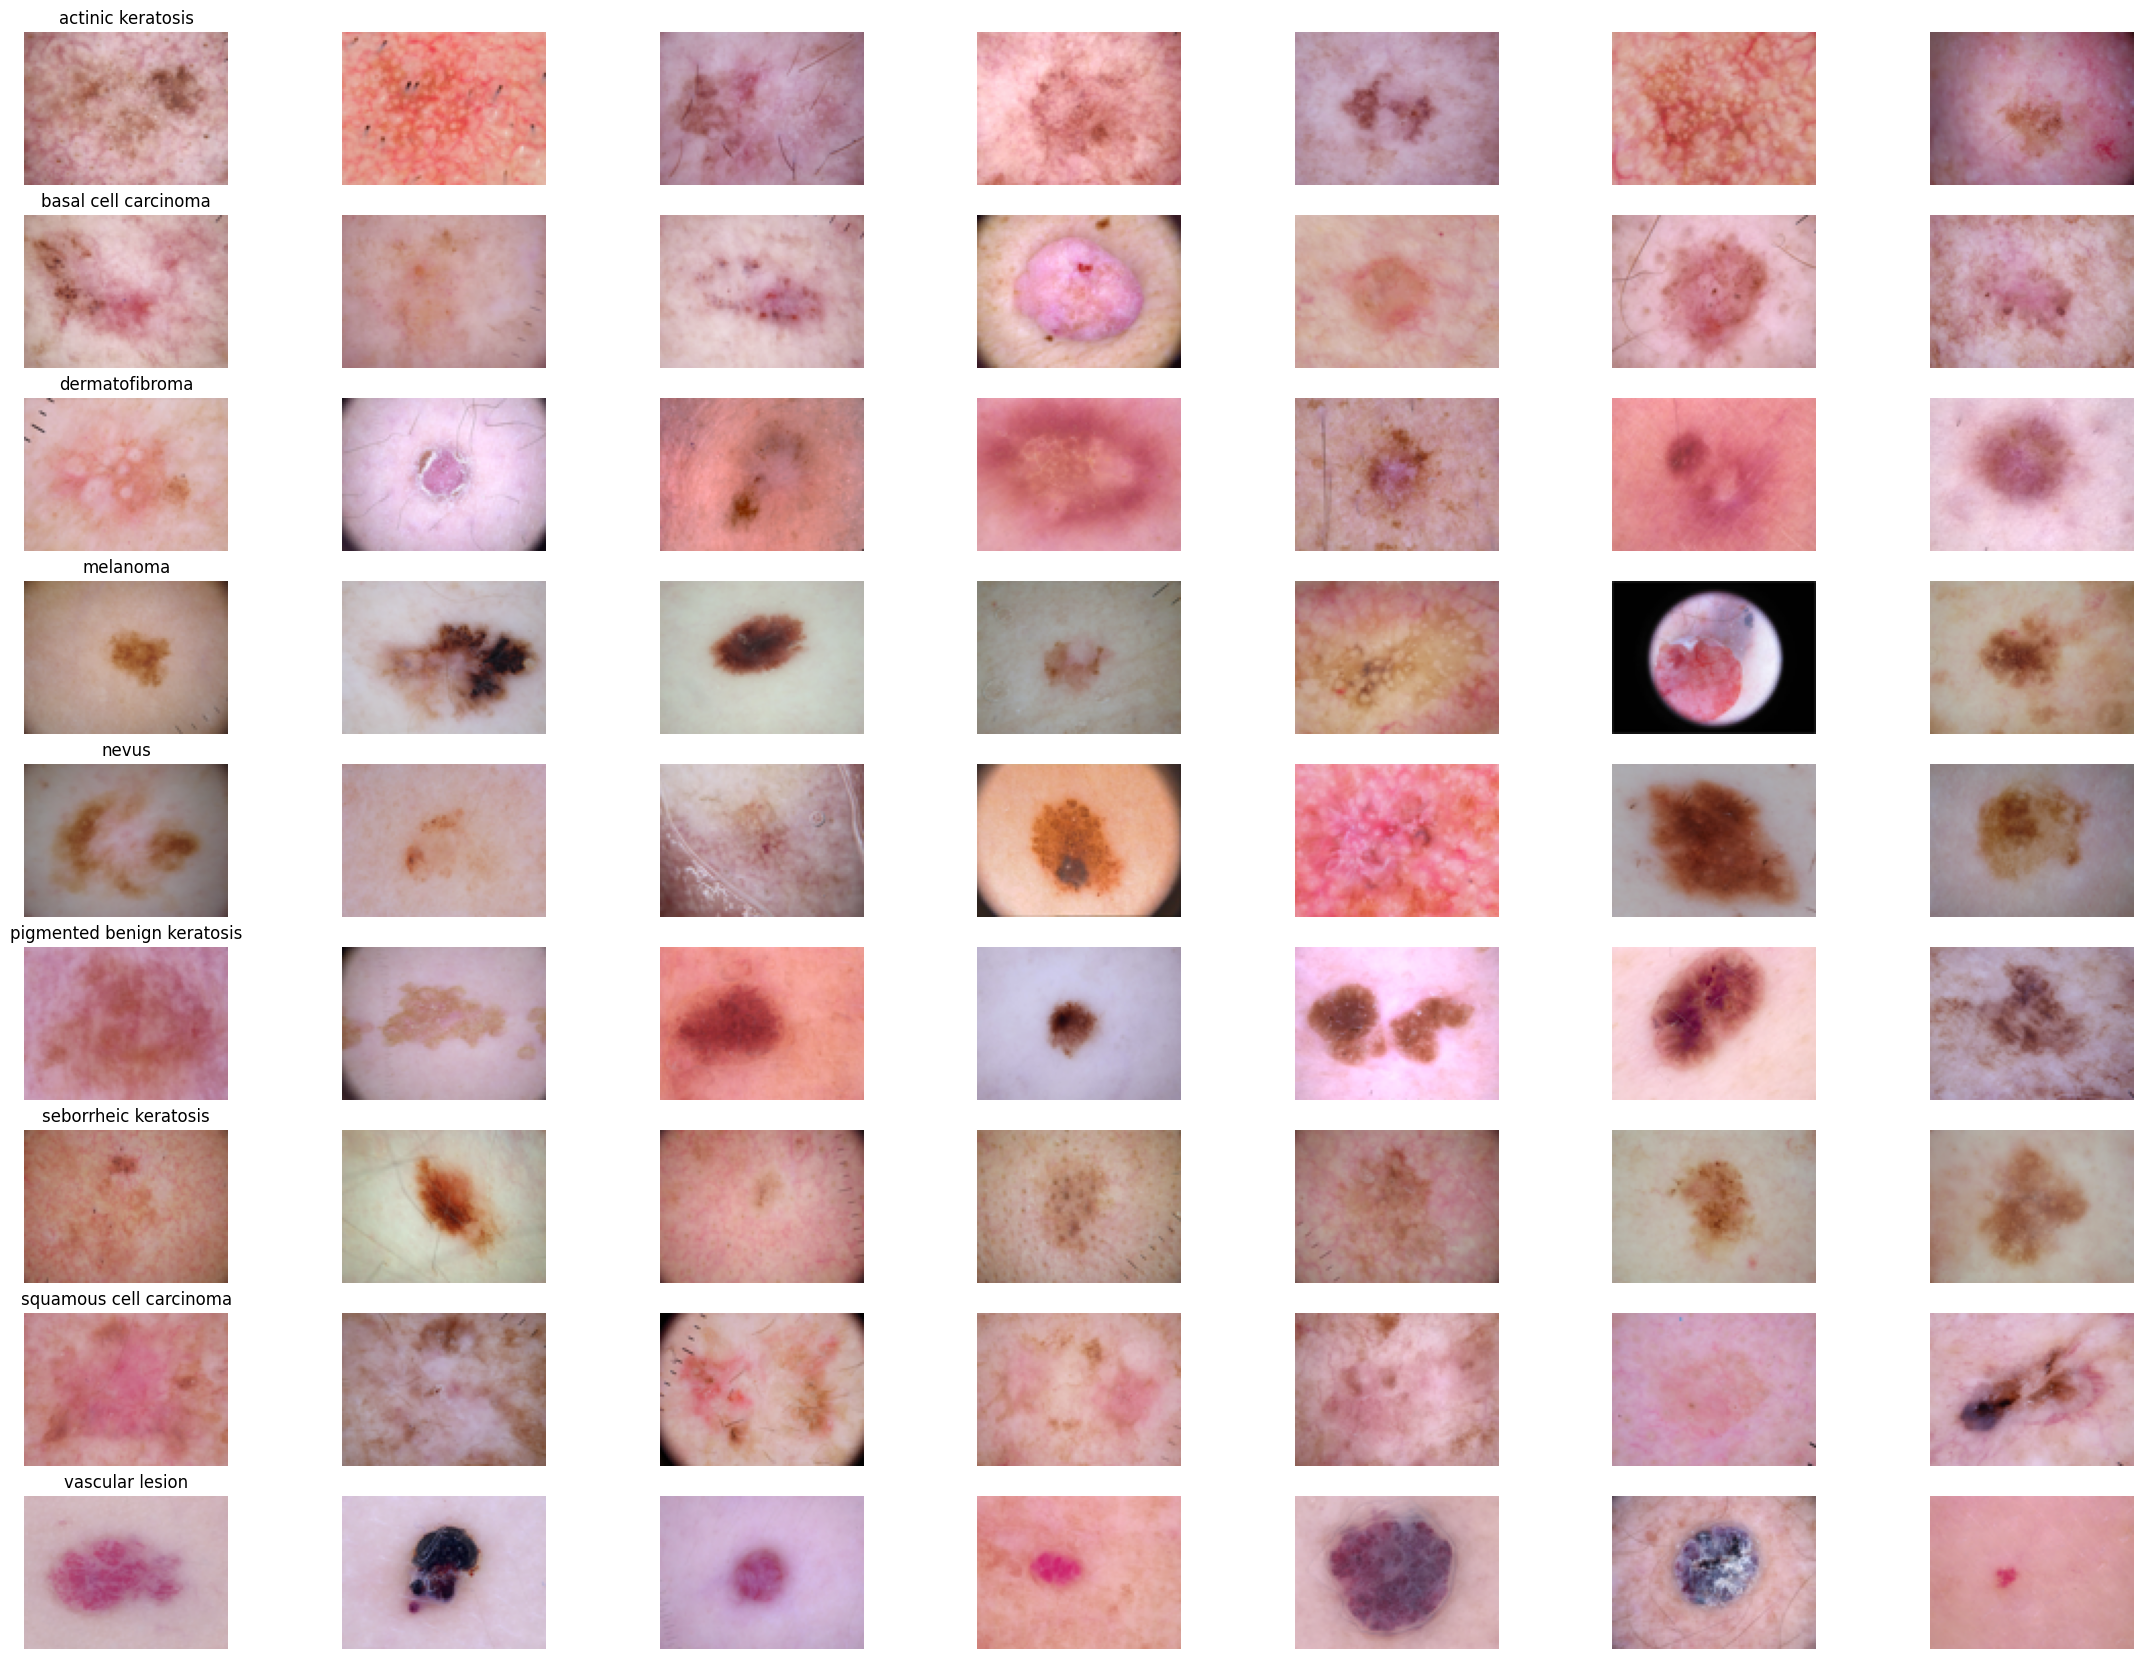

In [64]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [65]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

# Data Augmentation

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [67]:
# Create an empty list to store all image data (original and augmented)
all_images_data = []
max_images_per_class = 500 # Make sure this variable is defined

# Loop through each class and balance the data by augmenting images
for class_label in df['label'].unique():
    class_df = df[df['label'] == class_label]
    
    # First, add all the original images for this class to our list
    all_images_data.extend(class_df.to_dict('records'))
    
    # Calculate how many new images we need to generate
    num_images_needed = max_images_per_class - len(class_df)
    
    if num_images_needed > 0:
        # Get the numpy arrays of the original images to use for augmentation
        image_arrays_to_augment = class_df['image'].values
        
        # Randomly select images to augment. 'replace=True' allows us to pick the same image multiple times.
        selected_image_arrays = np.random.choice(image_arrays_to_augment, size=num_images_needed, replace=True)
        
        # Generate one new image for each selection
        for image_array in selected_image_arrays:
            # Reshape the image array to (1, height, width, channels) for the generator
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Create an iterator that will generate augmented versions of this single image
            iterator = datagen.flow(image_tensor, batch_size=1)
            
            # Get the next (and only) augmented image from the iterator
            augmented_image_array = next(iterator)[0].astype('uint8')
            
            # Add the new augmented image's data to our list
            all_images_data.append({
                'image_path': None, # Augmented images don't have a file path
                'label': class_label,
                'image': augmented_image_array
            })

# Create the final, balanced DataFrame from the list in a single, efficient operation
final_df = pd.DataFrame(all_images_data)

# Shuffle the final DataFrame to mix original and augmented images, then reset the index
df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Clean up the temporary DataFrame from memory
del final_df

> # Displaying the total number of images of each Class after Data Augmentation

In [68]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              500       
1               basal cell carcinoma           500       
2               dermatofibroma                 500       
3               melanoma                       500       
4               nevus                          500       
5               pigmented benign keratosis     500       
6               seborrheic keratosis           500       
7               squamous cell carcinoma        500       
8               vascular lesion                500       
------------------------------------------------------------
Total                                         4500      


# Spliting the Dataset into Train and Test 

In [69]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [70]:
features.head()

,image
0,"[[[205, 143, 121], [205, 140, 119], [205, 147,..."
1,"[[[168, 140, 128], [168, 138, 126], [167, 137,..."
2,"[[[184, 165, 160], [184, 166, 164], [186, 168,..."
3,"[[[184, 144, 169], [181, 138, 167], [179, 131,..."
4,"[[[161, 109, 162], [163, 110, 164], [166, 111,..."


In [71]:
target.head()

0    4
1    7
2    5
3    5
4    0
Name: label, dtype: int64

In [72]:
print(target.shape,features.shape)

(4500,) (4500, 1)


In [73]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [96]:
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization of Data

In [76]:
x_train = np.asarray(X_train['image'].tolist())
x_test = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

In [77]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Spliting data into training and Validation Split

In [78]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [79]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [80]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [81]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              307        89           104        500       
1               basal cell carcinoma           311        87           102        500       
2               dermatofibroma                 319        78           103        500       
3               melanoma                       314        92           94         500       
4               nevus                          333        69           98         500       
5               pigmented benign keratosis     315        85           100        500       
6               seborrheic keratosis           327        75           98         500       
7               squamous cell carcinoma        314        

In [82]:
df.groupby('label').size()

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
dtype: int64

In [83]:
input_shape = df['image'][0].shape

#  Model Architecture

In [84]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 3, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225,353 (92.41 MB)

 Trainable params: 23,996,297 (91.54 MB)

 Non-trainable params: 229,056 (894.75 KB)

#  Setting Optimizer

In [85]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Fitting of model

In [86]:
# Fit the model
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.2932 - loss: 2.2070 - val_accuracy: 0.3778 - val_loss: 2.6059 - learning_rate: 0.0010
Epoch 2/50


c:\Users\REVIN CHRISBERT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6449 - loss: 1.0046 - val_accuracy: 0.5806 - val_loss: 1.2464 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7694 - loss: 0.6409 - val_accuracy: 0.7097 - val_loss: 0.8492 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8405 - loss: 0.4437 - val_accuracy: 0.6889 - val_loss: 0.9314 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9091 - loss: 0.2619 - val_accuracy: 0.7028 - val_loss: 0.9355 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.9228 - loss: 0.1982 - val_accuracy: 0.7056 - val_loss: 1.2365 - learning_rate: 0.0010
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.9214 - loss: 0.2145 - val_accuracy: 0.7375 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9514 - loss: 0.1281 - val_accuracy: 0.73

# Model Evaluation

In [87]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 470ms/step - accuracy: 0.9736 - loss: 0.0353
Train: accuracy = 0.978125  ;  loss = 0.031075


In [88]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - accuracy: 0.7540 - loss: 1.5669
Testing: accuracy = 0.747778  ;  loss = 1.577162


29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 726ms/step


<Axes: >

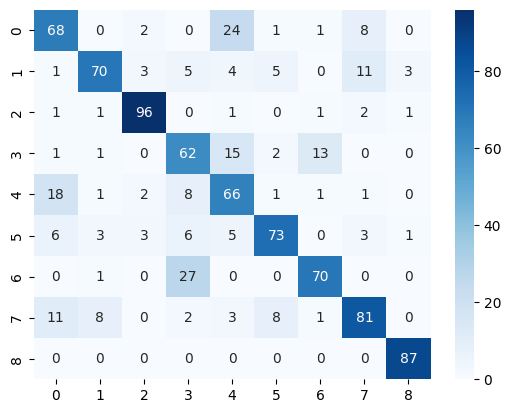

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.7478
Precision: 0.7577
Recall: 0.7511
F1-score: 0.7519
Kappa score: 0.7162


# Save the model

In [91]:
model.save("skinDiseaseDetectionUsningCNN.h5")

# Load the Saved Model

In [92]:
from tensorflow.keras.models import load_model

# Define the path to your saved model file
model_filepath = "skinDiseaseDetectionUsningCNN.h5"

# Load the model
model = load_model(model_filepath)

# You can print a summary to confirm it loaded correctly
print("Model loaded successfully!")
model.summary()

Model loaded successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 3, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225,355 (92.41 MB)

 Trainable params: 23,996,297 (91.54 MB)

 Non-trainable params: 229,056 (894.75 KB)

 Optimizer params: 2 (12.00 B)

In [105]:
from PIL import Image
import numpy as np

# --- 1. SET YOUR IMAGE PATH ---
# Change this to the full path of the image you want to test
image_path_to_test = r"C:\Users\REVIN CHRISBERT\Downloads\WhatsApp Image 2025-11-04 at 13.08.02_779a3a5b.jpg"

try:
    # --- 2. GET MODEL'S EXPECTED INPUT SIZE ---
    # Get (height, width) from the model's input
    model_height = model.input_shape[1]  # e.g., 75
    model_width = model.input_shape[2]   # e.g., 100
    
    # Create the correct (width, height) tuple for PIL's resize function
    pil_shape = (model_width, model_height) 
    
    # --- 3. LOAD AND PREPROCESS THE IMAGE ---
    print(f"Loading image from: {image_path_to_test}")
    
    # Open the image file
    img = Image.open(image_path_to_test)
    
    # Resize the image to the correct (width, height)
    img_resized = img.resize(pil_shape)
    
    # Convert the image to a numpy array
    image_array = np.asarray(img_resized)
    
    # --- 4. NORMALIZE THE IMAGE ---
    # You MUST use the *same* mean and std from your training data
    normalized_image = (image_array - x_train_mean) / x_train_std
    
    # --- 5. RESHAPE FOR PREDICTION ---
    # The model expects a "batch" of images. 
    # This adds a new dimension at the beginning: (1, 75, 100, 3)
    image_to_predict = np.expand_dims(normalized_image, axis=0)

    # --- 6. MAKE THE PREDICTION ---
    print("Model is making a prediction...")
    predictions = model.predict(image_to_predict)
    
    # Get the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # Get the human-readable class name from your label_map
    predicted_class_name = label_map[predicted_class_index]
    
    # Get the model's confidence
    confidence = np.max(predictions, axis=1)[0] * 100
    
    # --- 7. SHOW THE RESULT ---
    print("\n--- Prediction Result ---")
    print(f"The model predicts this is: {predicted_class_name.upper()}")
    print(f"Confidence: {confidence:.2f}%")

except FileNotFoundError:
    print(f"Error: The file was not found at {image_path_to_test}")
    print("Please double-check the file path and try again.")
except NameError as e:
    print(f"Error: {e}")
    print("Please make sure you have re-run the cells that define 'model', 'label_map', 'x_train_mean', and 'x_train_std'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading image from: C:\Users\REVIN CHRISBERT\Downloads\WhatsApp Image 2025-11-04 at 13.08.02_779a3a5b.jpg
Model is making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

--- Prediction Result ---
The model predicts this is: DERMATOFIBROMA
Confidence: 41.73%


In [102]:
import numpy as np

try:
    # --- 1. PREPARE LABELS (FORCED FLOAT32) ---
    # Convert labels to categorical and immediately cast to float32
    y_test_cat = to_categorical(y_test, num_classes=num_classes).astype('float32')
    
    # --- 2. PREPARE TEST IMAGES (FORCED FLOAT32) ---
    print("Preparing test images...")
    x_test_images = X_test['image'].tolist()
    
    # Stack images and immediately cast to float32
    x_test_stacked = np.stack(x_test_images).astype('float32') 
    
    # Cast mean and std to float32, just in case
    mean_f32 = np.float32(x_train_mean)
    std_f32 = np.float32(x_train_std)
    
    # Normalize using all float32 variables
    x_test_normalized = (x_test_stacked - mean_f32) / std_f32
    
    print("Test images are ready.")

    # --- 3. EVALUATE THE MODEL ---
    print("Evaluating model on test data...")
    loss, accuracy = model.evaluate(x_test_normalized, y_test_cat, verbose=1)

    print("-" * 30)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
except NameError as e:
    print(f"Error: {e}")
    print("A required variable is missing.")
    print("Please re-run your 'train_test_split' cell and your 'normalization' cell (the one that creates x_train_mean/std).")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Preparing test images...
Test images are ready.
Evaluating model on test data...
An unexpected error occurred: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.
